# Composition methods

In [1]:
# author: Christian Offen
# accompanying source code for the handbook article 
# "Solving ODEs for Nonlinear Dynamics with Symplectic and Geometric Integration" within "Handbook on Nonlinear Dynamics. Volume 2 Numerical Methods", World Scientific, editor: Vincent Acary

In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings

## 1 step functions and integrators

In [3]:
# generic method for fixpoint iterations to solve F(z)=z with initial value y0
function Fixpoint(F,y0; maxIter=10000, TOL=1e-16)
    y1 = F(y0); iter = 0;     
    while (norm(y1-y0)> TOL) && (iter < maxIter)
        y0 = y1
        y1 = F(y0)
        iter = iter+1
    end
    return y1
end

# Euler method for y'(t)=f(y(t)) with initial value y
function Euler(y,f,h)
    return y + h*f(y)
end

# implicit Euler method for y'(t)=f(y(t)) with initial value y
function IEuler(y,f,h)
    hY=Fixpoint( hY -> h*f(y+hY),0.0*y)
    return y+hY
end

# trapezoidal rule as composition of Euler and IEuler
function EulerIEuler(y,f,h)
    y=Euler(y,f,0.5*h)
    y=IEuler(y,f,0.5*h)
    return y
end

EulerIEuler (generic function with 1 method)

In [4]:
# generic function to apply 1-step function iteratively
function Integrator(method,y0,f,h,steps::Int)
    y = zeros(length(y0),steps+1)
    y[:,1] = y0
    for k=1:steps
        y[:,k+1] = method(y[:,k],f,h)
    end
    return y
end

Integrator (generic function with 1 method)

## composition strategies

In [5]:
# generic function to perform order increase by one (when order is even) via triple jump
function TripleJump(method,order::Int)
    s = 1/(order+1)
    gamma1=1/(2-2^s)
    gamma3=gamma1
    gamma2=1.0-2*gamma1
    function methodTripleJump(y,f,h)
        y= method(y,f,gamma1*h)
        y= method(y,f,gamma2*h)
        y= method(y,f,gamma3*h)
        return y
    end
    return methodTripleJump
end

TripleJump (generic function with 1 method)

In [6]:
# EulerComposition
# composition of order four of the Euler method and its adjoint, the implicit Euler method

a1 = (146+5*sqrt(19))/540
a2 = (-2+10*sqrt(19))/135
a3 = 1/5
a4 = (-23-20*sqrt(19))/270
a5 = (14-sqrt(19))/108

b5=a1; b4=a2; b3=a3; b2=a4; b1=a5;

function EulerComposition(y,f,h)
    
    y = IEuler(y,f,b1*h)
    y = Euler(y,f,a1*h)
    
    y = IEuler(y,f,b2*h)
    y = Euler(y,f,a2*h)
    
    y = IEuler(y,f,b3*h)
    y = Euler(y,f,a3*h)
    
    y = IEuler(y,f,b4*h)
    y = Euler(y,f,a4*h)
    
    y = IEuler(y,f,b5*h)
    y = Euler(y,f,a5*h)

    return y
end 

EulerComposition (generic function with 1 method)

In [7]:
# triple jump applied to trapezoidal rule (EulerIEuler) and to EulerComposition for an order increase by 1
Euler3 = TripleJump(EulerIEuler,2)
EulerComposition3 = TripleJump(EulerComposition,4);

## convergence tests

In [8]:
# definition of dynamical system y'(t)=f(y(t)) and its exact solution

f(y) = y # rhs
y0 = 1. # initial value
yExact(y) = y0*exp(y) # exact solution
T = 1.   # integration time
yend = yExact(T) # exact end value

# step sizes for convergence plot
hh = 2.0.^(-(2:10))
steps = Int.(T./hh);

# function to compute numerical error of a supplied 1-step method at step size h
function ConvergenceTest(h,method)
    N = Int(T/h)
    y=y0
    for k=1:N
        y = method(y,f,h)
    end
    return norm(yend - y)
end

ConvergenceTest (generic function with 1 method)

In [9]:
# evaluate convergence tests
convergenceEuler = ConvergenceTest.(hh,Euler)
convergenceIEuler = ConvergenceTest.(hh,IEuler)
convergenceEulerIEuler = ConvergenceTest.(hh,EulerIEuler)
convergenceEuler3 = ConvergenceTest.(hh,Euler3)

convergenceComposition = ConvergenceTest.(hh,EulerComposition);
convergenceComposition3 = ConvergenceTest.(hh,EulerComposition3);

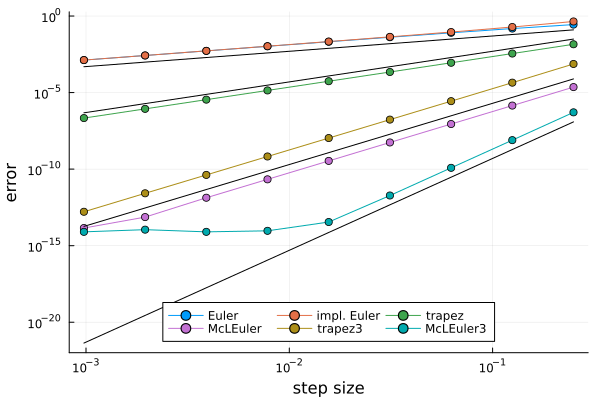

In [10]:
# plot convergence results
convPlot=plot(xaxis=:log,yaxis=:log,marker=:circle,legend=:bottom,legend_column=3,xlabel="step size",ylabel="error")
plot!(hh,convergenceEuler,xaxis=:log,yaxis=:log,marker=:circle,label="Euler",xlabel="step size",ylabel="error")
plot!(hh,convergenceIEuler,marker=:circle,label="impl. Euler")
plot!(hh,convergenceEulerIEuler,marker=:circle,label="trapez")
plot!(hh,convergenceComposition,marker=:circle,label="McLEuler")
plot!(hh,convergenceEuler3,marker=:circle,label="trapez3")
plot!(hh,convergenceComposition3,marker=:circle,label="McLEuler3")

plot!(hh,0.5*hh,color=:black,label="")
plot!(hh,0.5*hh.^2,color=:black,label="")
plot!(hh,0.02*hh.^4,color=:black,label="")
plot!(hh[1:9],0.0005*hh[1:9].^6,color=:black,label="")

## experiments with pendulum equation

In [11]:
# definition of dnymical system (mathematical pendulum)
FPendulum(y) = [y[2]; -cos(y[1])]; # rhs
y0 = [1., 0]  # init value
hPendulum = 0.01  # step size for numerical computation
steps = Int(40/hPendulum) # number of steps to reach integration end time 40
tPendulum = 0:hPendulum:hPendulum*steps # time mesh for plotting

# evaluation of numberical integrators
yPendulumEuler = Integrator(Euler,y0,FPendulum,hPendulum,steps)
yPendulumIEuler = Integrator(IEuler,y0,FPendulum,hPendulum,steps)
yPendulumEulerIEuler = Integrator(EulerIEuler,y0,FPendulum,hPendulum,steps)
yPendulumCompEuler = Integrator(EulerComposition,y0,FPendulum,hPendulum,steps);

In [12]:
# reference solution using 100 times smaller step sizes and a high order method
yPendulumRef = Integrator(EulerComposition,y0,FPendulum,hPendulum/100,steps*100);

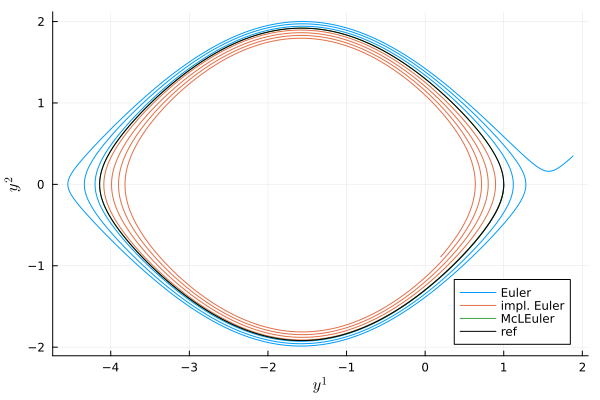

In [13]:
# plotting commands phase plots
PendulumPhasePlot=plot(yPendulumEuler[1,:],yPendulumEuler[2,:],label="Euler",xlabel=L"y^1",ylabel=L"y^2")
plot!(yPendulumIEuler[1,:],yPendulumIEuler[2,:],label="impl. Euler")
plot!(yPendulumCompEuler[1,:],yPendulumCompEuler[2,:],label="McLEuler")
plot!(yPendulumRef[1,1:100:end],yPendulumRef[2,1:100:end],color=:black,label="ref")

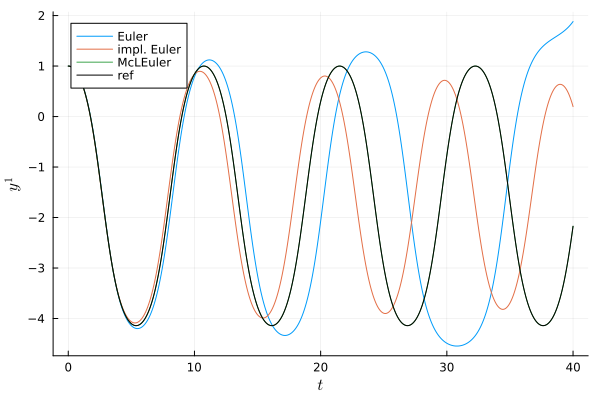

In [14]:
# plotting commands evolution
PendulumPlot = plot(tPendulum,yPendulumEuler[1,:],label="Euler",xlabel=L"t",ylabel=L"y^1")
plot!(tPendulum,yPendulumIEuler[1,:],label="impl. Euler")
plot!(tPendulum,yPendulumCompEuler[1,:],label="McLEuler")
plot!(tPendulum,yPendulumRef[1,1:100:end],color=:black,label="ref")

In [15]:
# long term integration with many more steps to identify phase difference between 2nd and 4th order method (both symplectic)
steps2 = 1000*steps
yPendulumEulerIEuler = Integrator(EulerIEuler,y0,FPendulum,hPendulum,steps2)
yPendulumCompEuler = Integrator(EulerComposition,y0,FPendulum,hPendulum,steps2);

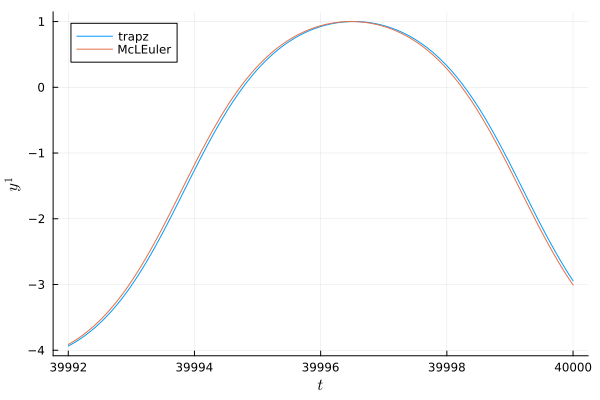

In [16]:
# plotting commands
tPendulum2 = 0:hPendulum:steps2*hPendulum
TrapMcLEuler = plot(xlabel=L"t",ylabel=L"y^1")
rangeoff = 800
plot!(tPendulum2[end-rangeoff:end],yPendulumEulerIEuler[1,end-rangeoff:end],label="trapz")
plot!(tPendulum2[end-rangeoff:end],yPendulumCompEuler[1,end-rangeoff:end],label="McLEuler")

In [17]:
# Message: The fourth and second order symplectic method almost coincide even after very long time. 
# This justifies using low order symplectic integrators